In [20]:
import os,re,sys,math
import pandas as pd
import time
import datetime
import numpy as np
import pickle
from functools import reduce
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy import sparse
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

In [4]:
train_path = 'data/dsjtzs_txfz_training.txt'
test_path = 'data/dsjtzs_txfz_test1.txt'

In [6]:

def inf_to_nan(x):
    for i in range(len(x)):
        if x[i] == float("inf") or x[i] == float("-inf"):
            x[i] = float('nan') # or x or return whatever makes sense
    return x


In [9]:
def feature(path):
    train = pd.read_csv(path,sep=' ',header=None,encoding='utf-8',names=['id','data','target','label'])
    train['data'] = train['data'].apply(lambda x:[list(map(float,point.split(','))) for point in x.split(';')[:-1]])
    
    train['target'] = train['target'].apply(lambda x: list(map(float,x.split(","))))
    train['target_x'] = train['target'].apply(lambda x: x[0])
    train['target_y'] = train['target'].apply(lambda x: x[1])
    train['data_x'] = train['data'].apply(lambda x: [i[0] for i in x ])
    train['data_y'] = train['data'].apply(lambda x: [i[1] for i in x ])
    train['data_t'] = train['data'].apply(lambda x: [i[2] for i in x ])
    train['data_x'] = train['data_x'].apply(lambda x: np.array(x))
    train['data_y'] = train['data_y'].apply(lambda x: np.array(x))
    train['data_t'] = train['data_t'].apply(lambda x: np.array(x))
    del train['data']
    
    #delt 
    train['delt_x'] = train['data_x'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_y'] = train['data_y'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_t'] = train['data_t'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_xy'] = train.delt_x**2 + train.delt_y**2
    train['delt_xy'] = train['delt_xy'].apply(lambda x: np.sqrt(x))
    #speed
    train['speed_x'] = (train.delt_x/train.delt_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))
    train['speed_y'] = (train.delt_y/train.delt_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))
    train['speed_xy'] = (train.delt_xy/train.delt_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))

    #delt_speed
    train['delt_speed_x'] = train['speed_x'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_speed_y'] = train['speed_y'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_speed_xy'] = train['speed_xy'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])
    train['delt_speed_t'] = train['delt_t'].apply(lambda x: np.array(x)[1:]-np.array(x)[:-1])

    #acc
    train['acc_speed_x'] = (train.delt_speed_x/train.delt_speed_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))
    train['acc_speed_y'] = (train.delt_speed_y/train.delt_speed_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))
    train['acc_speed_xy'] = (train.delt_speed_xy/train.delt_speed_t).apply(lambda x :inf_to_nan(x)).apply(lambda x :np.nan_to_num(np.array(x)))

    #轨迹长度
    train['len_x'] =  train['data_x'].apply(lambda x: len(x))

    
    #first
    train['first_data_x'] = train['data_x'].apply(lambda x : x[0])
    train['first_data_t'] = train['data_t'].apply(lambda x : x[0])
    train['first_data_y'] = train['data_t'].apply(lambda x : x[0])
    train['first_delt_x'] = train['delt_x'].apply(lambda x: x[0] if len(x) > 0 else 0)
    train['first_delt_t'] = train['delt_t'].apply(lambda x: x[0] if len(x) > 0 else 0)
    train['first_data_x_2'] = train['data_x'].apply(lambda x: x[1] if len(x) > 1 else 0)
    train['first_delt_speed_t'] = train['delt_speed_t'].apply(lambda x: x[0] if len(x) > 0 else 0)
    train['last_data_t'] = train['data_t'].apply(lambda x : x[0])
    train['last_data_x'] = train['data_x'].apply(lambda x: x[-1] if len(x) > 0 else 0)


        ##################### X_max与X_target关系
    train['X_max'] = train['data_x'].map(lambda x: x.max() if x.shape[0] > 0 else 0)
    train['get_target'] = train['X_max'] - train['target_x']

    
    feats=[
      'first_data_x',
     'first_data_t',
    # 'x_max_sub_x_end',
     'first_data_x_divide_len_x',
     'first_data_y',
     'first_delt_x',
     'first_delt_t',
     'first_speed_x',
     'first_delt_speed_t',
     'sum_delt_speed_t', 
     'sum_delt_t',
     'sum_speed_x',
     'last_data_t',
    'last_data_x',
    ]
    feats2=[ 'id',
      'speed_x','acc_speed_x','data_t','data_x','delt_t','target_x','target_y','data_y','get_target','X_max','len_x']
    
    return  train[feats2]

In [10]:
train = feature(train_path)
#test = feature(test_path)

In [11]:
train.head()

,id,speed_x,acc_speed_x,data_t,data_x,delt_t,target_x,target_y,data_y,get_target,X_max,len_x
0,1,"[0.518518518519, 0.5, 1.16666666667, 1.6470588...","[-0.00123456790123, -0.037037037037, 0.0177923...","[349.0, 376.0, 418.0, 442.0, 493.0, 547.0, 592...","[353.0, 367.0, 388.0, 416.0, 500.0, 584.0, 675...","[27.0, 42.0, 24.0, 51.0, 54.0, 45.0, 51.0, 51....",1420.5,202.0,"[2607.0, 2607.0, 2620.0, 2620.0, 2620.0, 2620....",318.5,1739.0,56
1,2,"[0.179487179487, 0.291666666667, 0.16666666666...","[-0.00747863247863, -0.00694444444444, -0.0037...","[190.0, 229.0, 253.0, 295.0, 340.0, 382.0, 436...","[283.0, 290.0, 297.0, 304.0, 311.0, 325.0, 339...","[39.0, 24.0, 42.0, 45.0, 42.0, 54.0, 48.0, 54....",1018.0,189.0,"[2490.0, 2490.0, 2490.0, 2490.0, 2490.0, 2503....",203.0,1221.0,68
2,3,"[2.0, 2.33333333333, 2.33333333333, 3.11111111...","[0.111111111111, 0.0, -0.0648148148148, -0.081...","[424.0, 445.0, 469.0, 499.0, 517.0, 541.0, 562...","[255.0, 297.0, 353.0, 423.0, 479.0, 542.0, 605...","[21.0, 24.0, 30.0, 18.0, 24.0, 21.0, 27.0, 21....",601.5,559.5,"[2503.0, 2503.0, 2529.0, 2542.0, 2555.0, 2568....",710.5,1312.0,80
3,4,"[2.33333333333, 1.4358974359, 0.933333333333, ...","[0.0997150997151, -0.0239316239316, -0.0058779...","[466.0, 514.0, 553.0, 613.0, 730.0, 751.0, 787...","[437.0, 549.0, 605.0, 661.0, 731.0, 780.0, 822...","[48.0, 39.0, 60.0, 117.0, 21.0, 36.0, 60.0, 60...",675.0,202.0,"[2724.0, 2711.0, 2724.0, 2750.0, 2789.0, 2802....",420.0,1095.0,62
4,5,"[0.194444444444, 0.777777777778, 0.77777777777...","[0.0324074074074, 0.0, -0.259259259259, 0.0457...","[73.0, 109.0, 163.0, 217.0, 265.0, 316.0, 364....","[248.0, 255.0, 297.0, 339.0, 451.0, 577.0, 717...","[36.0, 54.0, 54.0, 48.0, 51.0, 48.0, 60.0, 42....",787.0,189.0,"[2542.0, 2542.0, 2542.0, 2555.0, 2568.0, 2594....",1204.0,1991.0,89


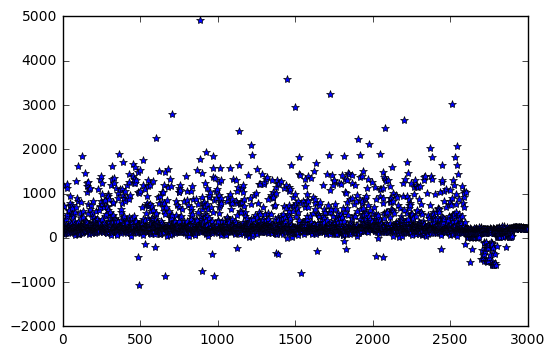

In [12]:
plt.plot(train.id,train.get_target,'b*')
plt.show()

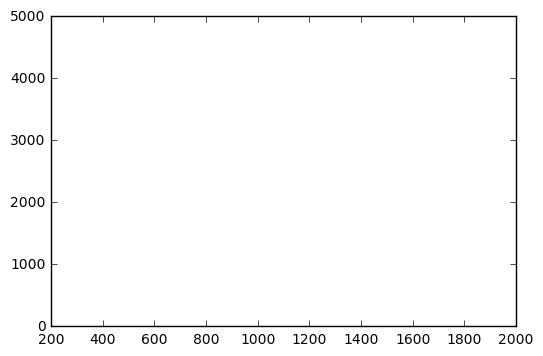

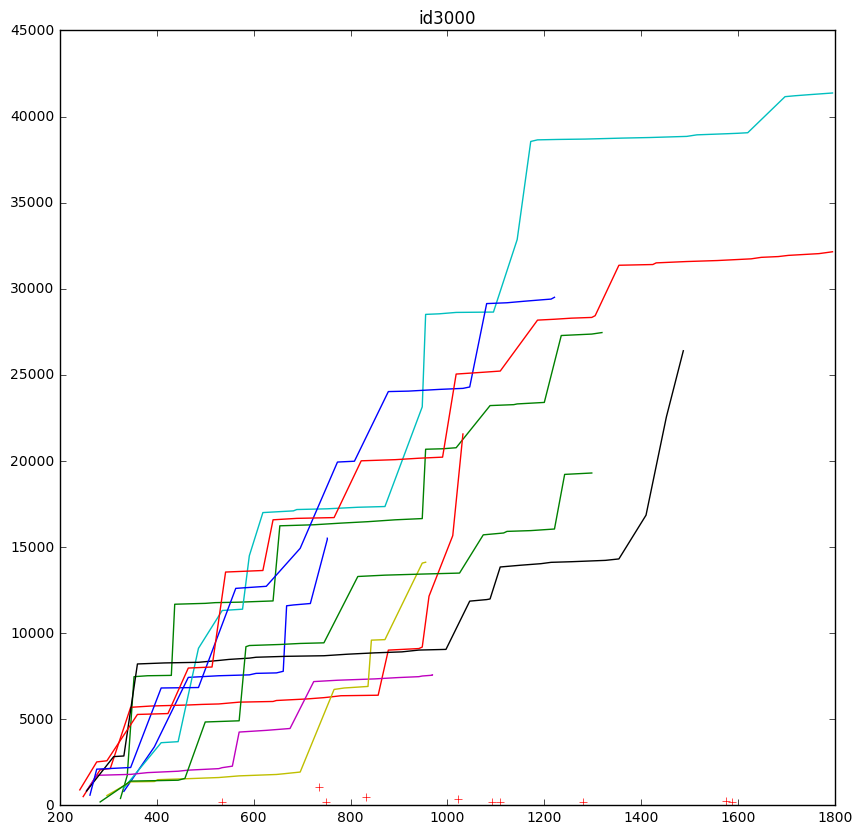

In [28]:
plt.xlim((200,2000))
plt.ylim((0,5000))
plt.figure(figsize=(10,10))
for i in range(2990,3000):
    #plt.plot(train.iloc[i]['data_x'],train.iloc[i]['data_t'],'b')
    plt.plot(train.iloc[i]['data_x'],train.iloc[i]['data_t'])
    plt.plot(train.iloc[i]['target_x'],train.iloc[i]['target_y'],'r+')
    plt.title('id{0}'.format(train.iloc[i]['id']))
    #plt.savefig('plot/xt{0}.png'.format(train.iloc[i]['id']))
plt.show()

In [31]:
plt.xlim((200,2000))
plt.ylim((0,5000))
for i in range(2990,3000):
    plt.figure(figsize=(10,10))
    #plt.plot(train.iloc[i]['data_x'],train.iloc[i]['data_t'],'b')
    plt.plot(train.iloc[i]['target_x'],train.iloc[i]['target_y'],'r+')
    plt.title('id{0}'.format(train.iloc[i]['id']))
    plt.savefig('plot/xt{0}.png'.format(train.iloc[i]['id']))
#plt.show()